This exercise will use a linear regression model to predict the value of a home based on a series of variables

See the data description for details on the data variables. 

# Evaluate the Data

In [3]:
import pandas as pd

data = pd.read_csv("houseSmallData.csv")

data.head()

,Unnamed: 0,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


$$ Y = X_{1}\beta_{1} + X_{2}\beta_{2} +X_{2}\beta_{2}...  $$

In this formula, the Y will be the value of the home, which will be determined by variables in the data, noed by X (independent variable). Beta's will be used to optimize Y (dependent variable), according to the linear regression. 

In [4]:
data.shape

(100, 82)

In [30]:
#get training data by taking 20 rows from data set
train = data.iloc[0:100, :]
train.head()
train.shape

(100, 82)

In [31]:
#investigate Sale Price
salePrice = train['SalePrice'] #confirm all rows have a value (no null or 0)
salePrice.describe() #evaluate data within the sale price column


count       100.000000
mean     173820.660000
std       72236.552886
min       40000.000000
25%      129362.500000
50%      153750.000000
75%      207750.000000
max      438780.000000
Name: SalePrice, dtype: float64

(array([ 2., 17., 35., 17., 11.,  8.,  5.,  3.,  1.,  1.]),
 array([ 40000.,  79878., 119756., 159634., 199512., 239390., 279268.,
        319146., 359024., 398902., 438780.]),
 <BarContainer object of 10 artists>)

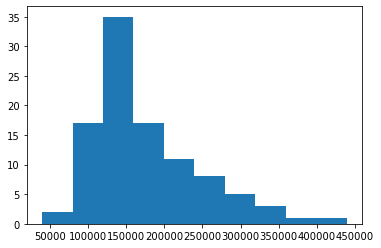

In [32]:
#plot histogram to visualize distribution of home prices
import matplotlib.pyplot as plt

plt.hist(train['SalePrice'])

Histogram suggests this is not a normally distributed data set (more like a log-normal distribution). To correct, take the log of teh sale price

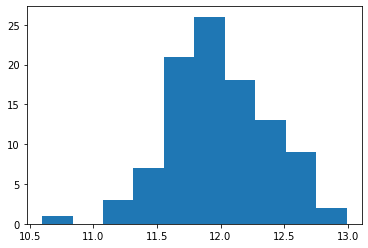

In [36]:
plt.hist(np.log(salePrice)) #if the log of the saleprice can be predicted then the sale price can be predicted via a transformation.
salePrice.skew()
target = np.log(salePrice) #make transformation to log data

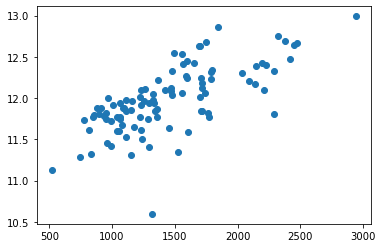

In [37]:
#evaluate GrLivArea by ploting against the transformed sale price data. Encouraging results would yield a positive, linear correlation
plt.scatter(train['GrLivArea'], y=target)

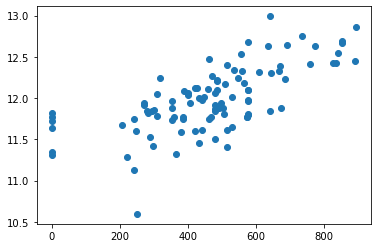

In [38]:
#evaluate another variable
plt.scatter(train['GarageArea'], y=target)

Both GrLivArea and GarageArea appear reasonably correlated with Sale Price. There do appear to be some null values in the GarageArea; however. 

# Clean the Data

In [42]:
#where are the nulls? 
nulls = pd.DataFrame(train.isnull().sum().sort_values(ascending = False))[0:20]
nulls

#values at the top of this list (variables with a lot of nulls) are discouraged from being included in the model

,0
PoolQC,100
Alley,94
MiscFeature,91
Fence,77
FireplaceQu,54
LotFrontage,14
GarageType,6
GarageYrBlt,6
GarageFinish,6
GarageQual,6


In [43]:
train.select_dtypes(include=[np.number]).interpolate().dropna(axis = 1)
sum(data.isnull().sum() != 0)
data.shape

(100, 82)

# Evaluate Cleaned Data

In [45]:
# select numeric columns
# calculate correlation factor
import numpy as np


numeric = train.select_dtypes(include=[np.number])
numeric.shape 
numeric.head()

,Unnamed: 0,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,YrSold,SalePrice
0,0,1,60,65.0,8450,7,5,2003,2003,196.0,...,61,0,0,0,0,NaN,0,2,2008,208500
1,1,2,20,80.0,9600,6,8,1976,1976,0.0,...,0,0,0,0,0,NaN,0,5,2007,181500
2,2,3,60,68.0,11250,7,5,2001,2002,162.0,...,42,0,0,0,0,NaN,0,9,2008,223500
3,3,4,70,60.0,9550,7,5,1915,1970,0.0,...,35,272,0,0,0,NaN,0,2,2006,140000
4,4,5,60,84.0,14260,8,5,2000,2000,350.0,...,84,0,0,0,0,NaN,0,12,2008,250000


In [46]:
#determine correlation
corr = numeric.corr() #use numeric column, not train
corr.shape

(40, 40)

# Set up Model

In [52]:
#What is correlated with Sale Price?
cols = corr['SalePrice'].sort_values(ascending = False)[0:6].index
cols

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageArea', 'GarageCars',
       'YearBuilt'],
      dtype='object')

In [53]:
#Select X, Y values for model
X = data[cols]
Y = X['SalePrice']
X = X.drop(['SalePrice'], axis = 1)#drop sale price from X
X

,OverallQual,GrLivArea,GarageArea,GarageCars,YearBuilt
0,7,1710,548,2,2003
1,6,1262,460,2,1976
2,7,1786,608,2,2001
3,7,1717,642,3,1915
4,8,2198,836,3,2000
...,...,...,...,...,...
95,6,1470,420,2,1993
96,7,1588,472,2,1999
97,4,960,432,1,1965
98,5,835,366,1,1920


In [55]:
#Build linear regression model
from sklearn import linear_model

#Use linear_model.LinearRegression() class to instantiate the linear regression model so it can be implemented
lr = linear_model.LinearRegression()

#build model, fit the data
model = lr.fit(X,Y)

#make predictions
predictions = model.predict(X)

print(f"R^2 is: {model.score(X,Y)}")


R^2 is: 0.8309859964337734


In [56]:
#how good is the model? Use R^2 as a memtric
model.score(X,Y) #what % of the sale price is predicted from the independent variables selected


0.8309859964337734

(array([ 2.,  4., 19., 26., 26., 13.,  6.,  2.,  0.,  2.]),
 array([-72416.69551558, -54597.83016337, -36778.96481115, -18960.09945894,
         -1141.23410673,  16677.63124549,  34496.4965977 ,  52315.36194991,
         70134.22730213,  87953.09265434, 105771.95800655]),
 <BarContainer object of 10 artists>)

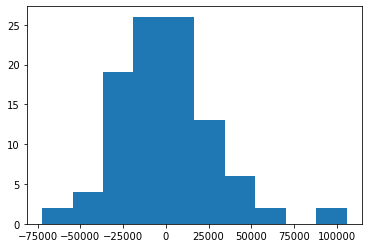

In [58]:
plt.hist(Y - predictions) #this should look like a normal distribution

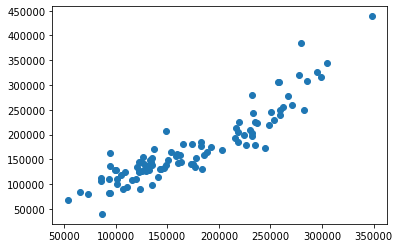

In [57]:
#scatter plot of predictions
plt.scatter(predictions, Y)

#ideally, should be a straight line with a slope of 1

The R2 value can likely be improved by recruiting additional variables. This also means the data in these variables needs to be scruitinized and cleaned to ensure it is good enough to employ in this model. 

# Test model against new data

In [59]:
#test model against data that it hasn't seen. use the jtest.csv file.

test = pd.read_csv('jtest.csv')
test.shape
test.head()

,Unnamed: 0,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,100,101,20,RL,NaN,10603,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,2,2010,WD,Normal,205000
1,101,102,60,RL,77.0,9206,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,178000
2,102,103,90,RL,64.0,7018,Pave,NaN,Reg,Bnk,...,0,NaN,NaN,NaN,0,6,2009,WD,Alloca,118964
3,103,104,20,RL,94.0,10402,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,198900
4,104,105,50,RM,NaN,7758,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,169500


In [60]:
#make test data

X = test[cols]
Y = X['SalePrice']
X = X.drop(['SalePrice'], axis = 1)

X

,OverallQual,GrLivArea,GarageArea,GarageCars,YearBuilt
0,6,1610,480,2,1977
1,6,1732,476,2,1985
2,5,1535,410,2,1979
3,7,1226,740,3,2009
4,7,1818,240,1,1931
...,...,...,...,...,...
95,6,1456,440,2,1976
96,7,1726,786,3,2007
97,8,3112,795,2,1918
98,6,2229,0,0,1912


In [61]:
#make predictions based on the test data

predictions = model.predict(X)
print(f"R^2 is: {model.score(X,Y)}")

R^2 is: 0.7403341313192593
